# Binary Classification:
In this notebook, we will build a convolutional neural network to classify images of cats and dogs. We have a dataset, which you can download directly on your desktop or run following commands to download it on google colab. Following are the key parts of this notebook:

1.   Dataset Preparation
2.   Building a Convolutional Model from Scratch
3.   Training Model
4.   Evaluating Model
5.   Transfer Learning and Fine Tuning




In [0]:
# We need to import multiple libraries as these are being used in this notebook. 

import os                                                                       # Import os for file handling mostly
import shutil                                                                   # Shutil, same as for file handling
import glob                                                                     # Glob is being used for file handling too
import cv2                                                                      # Import OpenCV
import numpy as np                                                              # Import numpy library
from pathlib import Path                                                        # Import Path from pathlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split                            # Train test split from model_selection module
from sklearn.metrics import confusion_matrix,classification_report              # get confusion matrix and classification report

import keras
from keras.utils import to_categorical                                          # To convert to one-hot encoding vector
from keras.layers import Dropout                                                # Import dropout submodule from keras.layers main module
from keras.models import Sequential                                             # To sequentially adding layers
from keras.layers.core import Activation,Flatten,Dense
from keras.preprocessing.image import ImageDataGenerator                        # Import for data preprocessing. More specifally, it is used in data augmentation
from keras.layers.convolutional import MaxPooling2D, Conv2D

Using TensorFlow backend.


In [0]:
# A function to create a a directory if it doesn't exist.
def create_directory(path,remove=True):
  if(os.path.exists(path)):
    if(remove==False):
      return
    shutil.rmtree(path)
  os.mkdir(path)


## Dataset Preparation
There are two ways of using data to train a model:
1. We can get data from internet or anywhere and place it in files ordered in a way that is understood by keras and is available to be read. 
2. Another way is to use keras datasets library to load data that have been pre included into the library.

We will look at each of the two cases in this complete tutorial. For this notebook, we will focus on first way of getting data and feeding into model.

For our binary classification problem, we will use Dogs and Cats dataset for kaggle competition available at url: https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

### Dataset Loading
Run following cell to download the dataset and unzip it.

In [0]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -qq kagglecatsanddogs_3367a.zip


--2019-07-07 12:22:21--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.60.72.32, 2600:1406:3:496::e59, 2600:1406:3:491::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.60.72.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M   108MB/s    in 7.3s    

2019-07-07 12:22:29 (107 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]

replace MSR-LA - 3467.docx? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


### Dataset Curation
We need to check for any corrupt images in our dataset which might hinder our training process. This is called dataset curation. Following cell curates or cleans the dataset by removing corrupt images.

In [0]:

def check_broken(imgfile):                                                      # Opens an image to makes sure that image is not broken
  try:
    im=cv2.imread(str(imgfile))
    if(im is None):
      return True
    return False
  except:
    return True
    #print(traceback.print_exc())
  
folders=os.listdir('PetImages/')                                                # All the broken images will be moved to another place
files=[]
for folder in folders:
  subfolderpath=os.path.join('PetImages/',folder)
  
  for filepath in list(Path(subfolderpath).glob('*')):
    if(check_broken(filepath)):
      files.append(filepath)
      os.remove(filepath)
print(len(files),'corrupt files have been removed.')

56 corrupt files have been removed.


We have two classes in our dataset:


*   Cat (We will represent cat class with label 0)
*   Dog(We will represent dog class with label 1)



In [0]:
!echo "Number of Images for Cat: `ls PetImages/Cat | wc -l`"
!echo "Number of Images for Dog: `ls PetImages/Dog | wc -l`"


Number of Images for Cat: 12476
Number of Images for Dog: 12470


### Subset of Dataset Selection and Dataset Split
After dataset curation, we have 12476 instances of Cat class and 12470 instances of Dog class. We can either use all the dataset or just a subset of dataset. For simplicity, we will use **5000** images only. But to see complete results of the model, you should use all images: 12476 +  12470. You can set the variable ***images_to_use = 24946***

After selecting images, we will also split our data into **train**, **test** and **validation** sets. 

In [0]:
images_to_use=5000                                                              # Only use 5000 images from data (to shorten the training time)

#following two lines will give us complete paths of cats and dogs images
catimages=np.array(glob.glob('PetImages/Cat/*'))                                # Get paths to all cat images
dogimages=np.array(glob.glob('PetImages/Dog/*'))                                # Get paths to all dog images

random_selection=np.random.choice(len(catimages),images_to_use//2)              # Randomly selected indices of images
catimages=catimages[random_selection].tolist()                                  # Cat images of randomly selected indices

random_selection=np.random.choice(len(dogimages),images_to_use//2)              # Randomly selected indices of dog images
dogimages=dogimages[random_selection].tolist()                                  # Dog images of randomly selected indices



#cat images are numerically labeled as 0 and dog images are labeled as 1
catlabels=[0]*len(catimages)                                                    # cat images labeled as 
doglabels=[1]*len(dogimages)                                                    # Dog images labeled as 1

#We will combine cat and dog images to build our complete dataset. 
all_images=catimages+dogimages                                                  # Combine all images
all_labels=catlabels+doglabels                                                  # Combine all labels
print('all images length:',len(all_images))
print('all labels length:',len(all_labels))

# 80 - 20 train-test split for our data
x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=43)

# we will further divide this train data into train data and validation data with 90 - 10 split:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.1,random_state=7)

print('train set size: ',len(x_train))
print('test set size: ',len(x_test))
print('validation set size: ',len(x_val))

all images length: 5000
all labels length: 5000
train set size:  3600
test set size:  1000
validation set size:  400


### Dataset Organization
We will organize train, test and validation data into form which is recognized by keras. For classification problem, we need create train, test and validation directories which would contain respective data. Then inside each directory, we will have folders with names of classes and each of that folder will have images inside it. 

In [0]:
# Now, we need to create separate directories for train, test and validation data and place images in respective folders
X=[x_train,x_test,x_val]                                                        # Just to make the process convenient, the arrays are enclosed together in an array
Y=[y_train,y_test,y_val]                                                        # Labels are enclosed together in array
C1=['train','test','val']
C2=['Cat','Dog']

#create new directory to store train, test and validation images for each category and create separate folder for each class (Cat and Dog)
create_directory('data')

for c1 in C1:
  create_directory(os.path.join('data',c1))
  for c2 in C2:
    create_directory(os.path.join('data',c1,c2))

#Copy files to new directories
for i,(x_data,y_data) in enumerate(zip(X,Y)):
  print('Copying',C1[i],'files')
  for img,label in zip(x_data,y_data):
    shutil.copy(img,os.path.join('data/',C1[i],C2[label]))
    

Copying train files
Copying test files
Copying val files


In [0]:

!echo "Number of Cat Images for Training set: `ls data/train/Cat | wc -l`"
!echo "Number of Dog Images for Training set: `ls data/train/Dog | wc -l`"

!echo "Number of Cat Images for Validation set: `ls data/val/Cat | wc -l`"
!echo "Number of Dog Images for Validation set: `ls data/val/Dog | wc -l`"

!echo "Number of Cat Images for Test set: `ls data/test/Cat | wc -l`"
!echo "Number of Dog Images for Test set: `ls data/test/Dog | wc -l`"


Number of Cat Images for Training set: 179
Number of Dog Images for Training set: 180
Number of Cat Images for Validation set: 24
Number of Dog Images for Validation set: 16
Number of Cat Images for Test set: 47
Number of Dog Images for Test set: 53


### Dataset Visualization
Let's visualize a few samples from our training data.

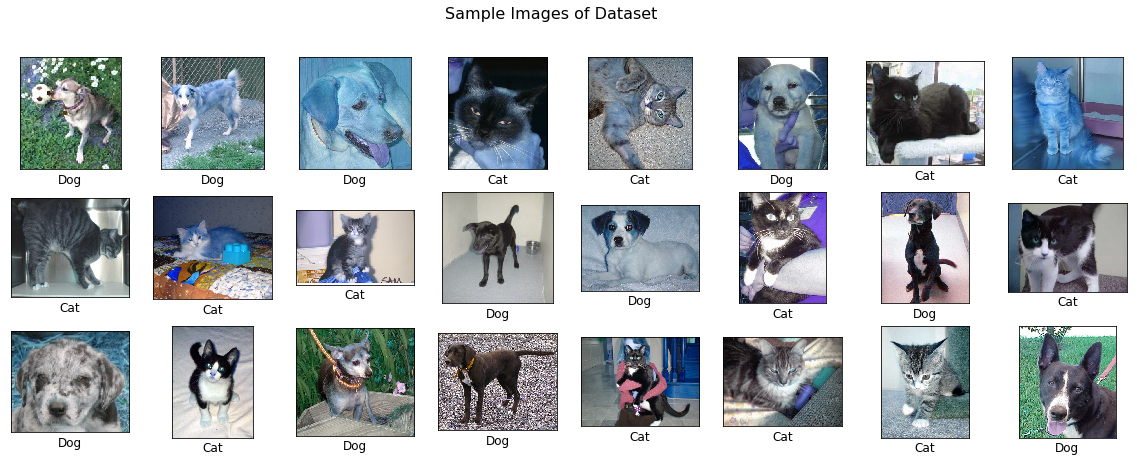

In [0]:

plt.figure(figsize=(20,7))                                                      # Initializing a figure of 20 x 7 in size
plt.suptitle('Sample Images of Dataset',fontsize=16)
for i in range(24):                                                             # Have multiple subplot images and randomly insert cats and dogs images
    plt.subplot(3,8,i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(cv2.imread(x_train[i]), cmap='gray')                             # Show image in the subplot
    plt.xlabel(C2[y_train[i]],fontsize=12)                                      # Set x label of each subplot image
plt.show()

## Building Convolutional Neural Network
We can use some predefined CNN architectures e.g. AlexNet, LeNet, VGG etc. but for our understanding, we will build a simple convolutional network that can learn the patterns to differentiate between cats and dogs. 

In [0]:
def build_CNN_model(inputshape):                                                # Function to build a convolutional neural network
  model=Sequential()                                                            # Sequential type to build model by adding layers

  model.add(Conv2D(64,(3,3),input_shape=inputshape))                            # Convolutional layer with 64 kernels of size (3 x 3)
  model.add(Activation('relu'))                                                 # Relu activation layer
  model.add(Conv2D(64,(3,3)))                                                   # Convolutional layer with 64 kernels of size (3 x 3)
  model.add(Activation('relu'))                                                 # Relu activation layer
  model.add(MaxPooling2D(pool_size=2,strides=2))                                # Maxpooling layer with kernel = 2 x 2 shape

  model.add(Conv2D(64,(3,3)))                                                   # Convolutional layer with 64 kernels of size (3 x 3)
  model.add(Activation('relu'))                                                 # Relu activation layer
  model.add(Conv2D(64,(3,3)))                                                   # Convolutional layer with 64 kernels of size (3 x 3)
  model.add(Activation('relu'))                                                 # Relu activation layer
  model.add(MaxPooling2D(pool_size=2,strides=2))                                # Maxpooling layer with kernel = 2 x 2 shape

  model.add(Conv2D(32,(3,3)))                                                   # Convolutional layer with 64 kernels of size (3 x 3)
  model.add(Activation('relu'))                                                 # Relu activation layer
  model.add(Conv2D(32,(3,3)))                                                   # Convolutional layer with 64 kernels of size (3 x 3)
  model.add(Activation('relu'))                                                 # Relu activation layer
  model.add(MaxPooling2D(pool_size=2,strides=2))                                # Maxpooling layer with kernel = 2 x 2 shape

  #this will convert all the pixels of image to flat tensor
  model.add(Flatten())

  #add some fully connected layers
  model.add(Dense(1024))                                                        # Fully connected layer with 1024 neurons 
  model.add(Activation('relu'))                                                 # Relu activation layer
  model.add(Dropout(0.2))                                                       # Dropout layer with dropout rate of 0.2
  
  model.add(Dense(512))                                                         # Fully connected dense layer with 512 neurons
  model.add(Activation('relu'))                                                 # Relu activation layer
  model.add(Dropout(0.2))                                                       # Dropout layer with dropout rate of 0.2
  
  #a fully connected layer with 2 neurons that represent the probability to belong to Cat or Dog
  model.add(Dense(2))

  #a softmax to get probabilities of each class
  model.add(Activation('softmax'))
  return model


### Model Summary:

In [0]:
build_CNN_model(inputshape=(224,224,3)).summary()                               # Summary of the model with input shape = (224 x 224 x 3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
activation_52 (Activation)   (None, 222, 222, 64)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 220, 220, 64)      36928     
_________________________________________________________________
activation_53 (Activation)   (None, 220, 220, 64)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 108, 108, 64)      36928     
_________________________________________________________________
activation_54 (Activation)   (None, 108, 108, 64)      0         
__________

## Training
We will prepare variables and will setup directories for training our model. This includes creating directories for storing weights and logs. Moreover, we can set callback functions that will be called during training after a fixed number of epochs.

In [0]:
batchsize=32                                                                    # Use batchsize of 32 (Train the model with 32 input images as one batch)
epochs=10                                                                       # Train the model for 10 epochs
nonaugweightsdir='nonaugcheckpoints/'                                           # Directory to store non augmented weights
augweightsdir='augcheckpoints/'                                                 # Directory to store augmented weights
logdir='logs/'                                                                  # Directory to store logs
categories=['Without Augmentation','With Augmentation']                        

#save model weights after every 2 epochs.
saveafter=2

create_directory(nonaugweightsdir,remove=False)                                 # Create directory for storing model weights with non-augmented data
create_directory(augweightsdir,remove=False)                                    # Create directory for storing model weights with augmented data
create_directory(logdir,remove=False)                                           # Create directory for storing log

### Data Generator
We can manually write code to load images into memory and feed to our convolutional model but we will use ImageDataGenerator class provided by Keras. Using this class, we can iterate through our images in batches and feed them to our model. Besides image loading, this class provides functionality to preprocess images (e.g. pixel scaling and augmentation). This also allows us to only load images while feeding to model. This way, we avoid storing a large number of images in memory as compared to some other methods available e.g. using data from keras library.

Our convolutional network model takes fixed size input images while our dataset contains images of different shapes. We need to set a fixed input size and resize all images to that size. Let's use 224 x 224 x 3 dimensions for input image.

Finally, we will build two data generator types: 

1.   Without any augmentation
2.   With data augmentation: shift, rotation, shear, zoom, horizontal and vertical flip

We will also be able to see how augmentation can help learn patterns in image variations


In [0]:
# Initialize instance of data generator class

# Without augmentation - Normalize the image pixel values
nonauggenerator=ImageDataGenerator(rescale=1.0/255.0)

# With augmentation - includes rotation, shift, zoom , shear and flip
auggenerator=ImageDataGenerator(rotation_range=30, rescale=1./255, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2, 
                             shear_range=0.2, horizontal_flip=True, fill_mode='nearest')

generators=[nonauggenerator,auggenerator]

# Three iterators: for train, test and validation data and each iterator type has two entities (one for augmented data and 
# other for nonaugmented)

training_iterators=[]
testing_iterators=[]
validation_iterators=[]

# Use train, test and val data generators
for generator in generators:
  training_iterators.append(generator.flow_from_directory('data/train/',target_size=(224,224),class_mode='categorical',batch_size=batchsize))
  testing_iterators.append(generator.flow_from_directory('data/test/',target_size=(224,224),class_mode='categorical',batch_size=batchsize))
  validation_iterators.append(generator.flow_from_directory('data/val/',target_size=(224,224),class_mode='categorical',batch_size=batchsize))

Found 359 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 359 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


**Checkpoint**: The model weights will be stored after n epoch(n is defined by saveafter variable above). This will allow us to retrieve the model weights later, for further training or model evaluation.


In [0]:
# Checkpoints callbacks for model with augmented data and with non augmented data
nonaugcheckpoints=keras.callbacks.ModelCheckpoint(os.path.join(nonaugweightsdir,"weights.{epoch:02d}-{val_loss:.2f}.hdf5"), monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=saveafter)
augcheckpoints=keras.callbacks.ModelCheckpoint(os.path.join(augweightsdir,"weights.{epoch:02d}-{val_loss:.2f}.hdf5"), monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=saveafter)
checkpoints=[nonaugcheckpoints,augcheckpoints]

## Training Convolutional Neural Network
We will initialize the convolutional neural network, that we have already built, to classify dogs and cats images. We will train the model for a few number of epochs and will analyze its results. 


In [0]:
#we need to build two models, one for each data (with augmentation and without augmentation)
models=[build_CNN_model(inputshape=(224,224,3)),build_CNN_model(inputshape=(224,224,3))]
model_outputs=[]
for it,model in enumerate(models):
  print('\nTraining',categories[it])
  
  # Compile model (configure loss function, metrics and optimizer)
  model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer='rmsprop')
  
  # Store model progress as hist object
  model_outputs.append(model.fit_generator(training_iterators[it], steps_per_epoch=len(training_iterators[it]),verbose=1,epochs=epochs,validation_data=validation_iterators[it],validation_steps=len(validation_iterators[it]),shuffle=True,callbacks=[checkpoints[it]]))

W0707 08:52:18.262475 139932930942848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0707 08:52:18.286149 139932930942848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0707 08:52:18.293701 139932930942848 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Training Without Augmentation
Epoch 1/10
12/12 [==============================] - 176s 15s/step - loss: 7.2163 - acc: 0.5063 - val_loss: 9.6181 - val_acc: 0.4000
Epoch 2/10
12/12 [==============================] - 171s 14s/step - loss: 8.3382 - acc: 0.4798 - val_loss: 9.6181 - val_acc: 0.4000
Epoch 3/10
12/12 [==============================] - 171s 14s/step - loss: 8.3382 - acc: 0.4798 - val_loss: 9.6181 - val_acc: 0.4000
Epoch 4/10
12/12 [==============================] - 171s 14s/step - loss: 8.0629 - acc: 0.4970 - val_loss: 9.6181 - val_acc: 0.4000
Epoch 5/10
12/12 [==============================] - 172s 14s/step - loss: 8.0629 - acc: 0.4970 - val_loss: 9.6181 - val_acc: 0.4000
Epoch 6/10
12/12 [==============================] - 172s 14s/step - loss: 7.9253 - acc: 0.5056 - val_loss: 9.6181 - val_acc: 0.4000
Epoch 7/10
12/12 [==============================] - 172s 14s/step - loss: 7.7877 - acc: 0.5142 - val_loss: 9.6181 - val_acc: 0.4000
Epoch 8/10
12/12 [===========================

### Visualizing Training Loss and Accuracies

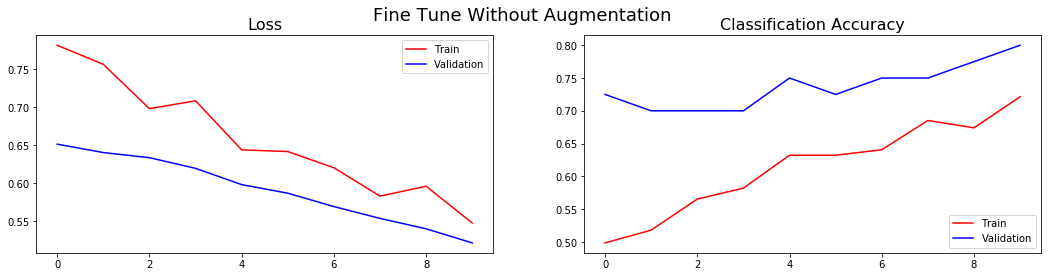

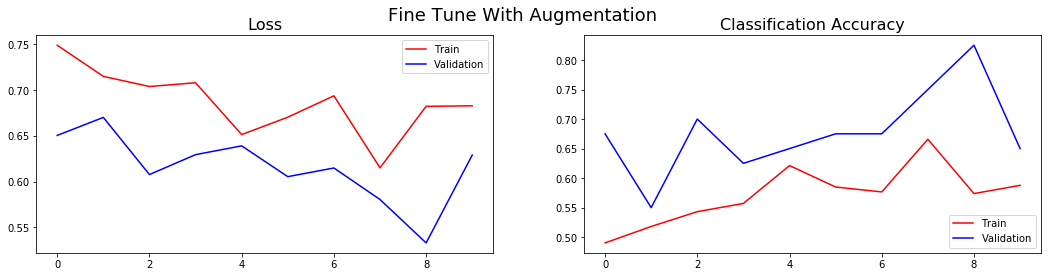

In [0]:
def summarize_stats(history,title):                                             # Plot the progress/stats of the model
  # loss 
  plt.figure(figsize=(18,4))                                                    # Initialize a figure
  plt.subplot(1,2,1)                                                            # Initialize subplots
  plt.suptitle(title,fontsize=18)                                               # Title of complete image
  plt.title('Loss',fontsize=16)                                                 # Title of subplot
  plt.plot(history.history['loss'], color='red', label='Train')                 # Plot the training loss
  plt.plot(history.history['val_loss'], color='blue', label='Validation')       # Plot the validation loss
  plt.legend(loc='upper right')                                                 # Put legends on top right corner
  # accuracy
  plt.subplot(1,2,2)
  plt.title('Classification Accuracy',fontsize=16)                              # Set title of second subplot
  plt.plot(history.history['acc'], color='red', label='Train')                  # Plot training accuracy
  plt.plot(history.history['val_acc'], color='blue', label='Validation')        # Plot validation accuracy
  
  plt.legend(loc='lower right')
  plt.show()
  
for it,model in enumerate(models):
  summarize_stats(model_outputs[it],title=str(categories[it]))                  # For all the types of models, plot hist object stats


## Testing


### Model Weights
The weights of the model were stored in **nonaugcheckpoints/** directory and **augcheckpoints/** directory, after every 2 epochs. We will list down those weights files.

In [0]:
print('\nModel for Non Augmented Data: ')
print(os.listdir('nonaugcheckpoints/'))
print('\nModel for Augmented Data: ')
print(os.listdir('augcheckpoints/'))


Model for Non Augmented Data: 
['weights.10-6.41.hdf5', 'weights.04-0.70.hdf5', 'weights.08-6.41.hdf5', 'weights.06-0.78.hdf5', 'weights.02-0.70.hdf5']

Model for Augmented Data: 
['weights.04-0.69.hdf5', 'weights.10-0.70.hdf5', 'weights.06-0.69.hdf5', 'weights.02-0.68.hdf5', 'weights.08-0.69.hdf5']


### Weight Loading
For our CNN model, we will load weights from file and evalute on test data. We can load from any weight file stored in directory **checkpoints/**

In [0]:
models[0].load_weights(glob.glob('nonaugcheckpoints/*')[-1])                    # Load model weights trained with non augmented data
models[1].load_weights(glob.glob('augcheckpoints/*')[-1])                       # Load model weights trained with augmented data

for it,model in enumerate(models):
  print(categories[it])
  
  # Evaluate model on test data
  test_loss, accuracy = model.evaluate_generator(testing_iterators[it],len(testing_iterators[it]), verbose=1)
  print('Evaluation loss: %.2f, Accuracy: %.2f' % (test_loss,accuracy * 100.0)) # Print evaluation loss and accuracy 


Without Augmentation
7/7 [==============================] - 12s 2s/step
Evaluation loss: 0.69, Accuracy: 53.00
With Augmentation
7/7 [==============================] - 15s 2s/step
Evaluation loss: 0.69, Accuracy: 53.00


### Visualizing Predictions

In [0]:
predictions=[]
for it,model in enumerate(models):                                              # Do for each type of model
  print(categories[it])
  
  # Get predictions for each type of model
  predictions.append(model.predict_generator(testing_iterators[it],len(testing_iterators[it])))
  
random_selection=np.random.choice(len(x_test),24)

Without Augmentation
With Augmentation


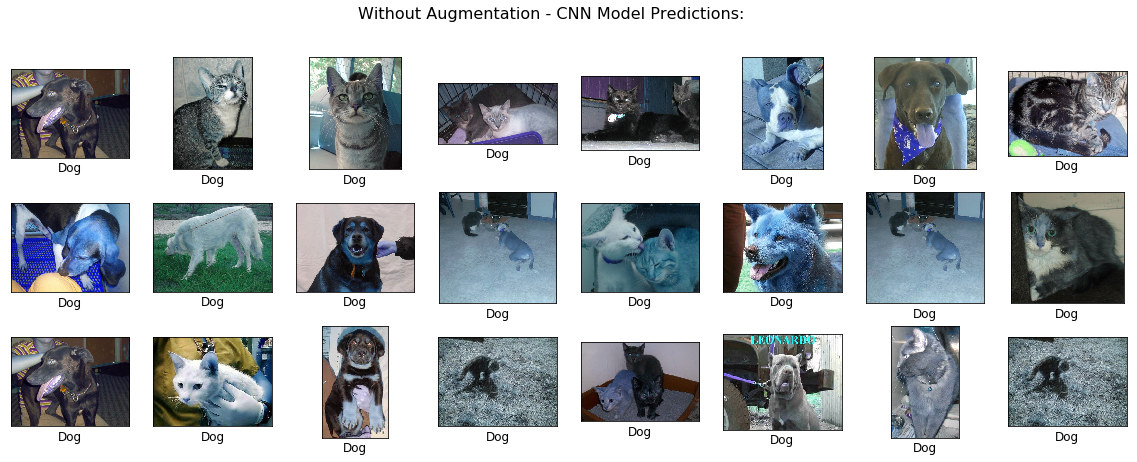

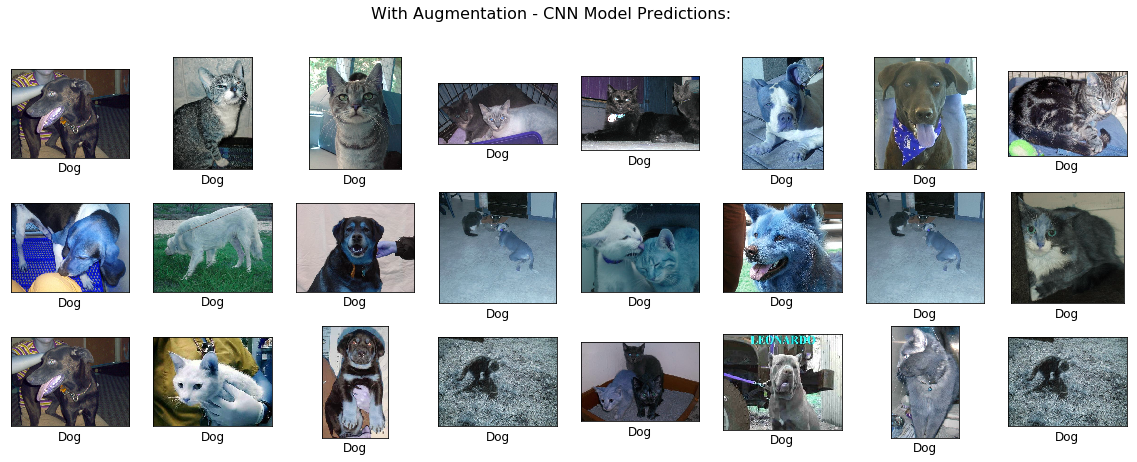

In [0]:
for it,prediction in enumerate(predictions):                                    # For all the predictions from model
  plt.figure(figsize=(20,7))                                                    # Initialize a figure
  plt.suptitle(str(categories[it])+' - CNN Model Predictions:',fontsize=16)
  for i in range(24):                                                           # 24 subplots in total
      plt.subplot(3,8,i+1)                                                      # Select a subplot
      plt.grid(False)                                                           # Set the grid off (no gridlines)
      plt.xticks([])                                                            # No numbers in x axis
      plt.yticks([])                                                            # No numbers in y axis
      plt.imshow(cv2.imread(x_test[random_selection[i]]), cmap='gray')
      plt.xlabel(str(C2[np.argmax(prediction[random_selection[i]])]),fontsize=12)
  plt.show()

### Confusion Matrix:
Confusion matrix evaluates the model to see which classes have been mostly correctly classified and which classes are hard for the model to classify. The diagonal elements show for which the actual label of the image and model predicted label are same while off-diagonal elements show misclassified image classes. 

(100, 2)

 Without Augmentation Accuracy Metrics for each class:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        47
           1       0.53      1.00      0.69        53

    accuracy                           0.53       100
   macro avg       0.27      0.50      0.35       100
weighted avg       0.28      0.53      0.37       100


 With Augmentation Accuracy Metrics for each class:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        47
           1       0.53      1.00      0.69        53

    accuracy                           0.53       100
   macro avg       0.27      0.50      0.35       100
weighted avg       0.28      0.53      0.37       100



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


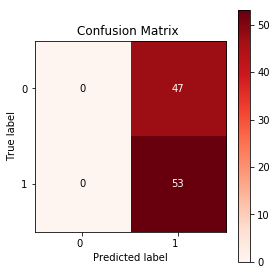

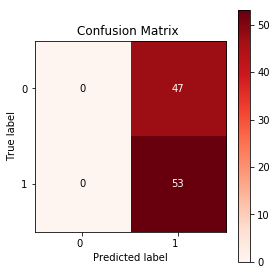

In [0]:
def plot_confusion_matrix(y_true, y_pred, titletxt,
                          cmap=plt.cm.Reds):                                    # Function to plot confusion matrix
    
    cm = confusion_matrix(y_true, y_pred)                                       # Get confusion matrix based on prediction values and actual values
    classes = range(0,2)                                                        # As we only have two classes: cats and dogs

    fig, ax = plt.subplots(figsize=(4,4))                                       # Initialize a figure
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)                      # Show confusion matrix with passed cmap
    ax.figure.colorbar(im, ax=ax)                                               # Choosing color bar
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix ',
           ylabel='True label',
           xlabel='Predicted label')                                            # Setting some properties of axes/subplot

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

one_hot_y_test=to_categorical(y_test,num_classes=2)                             # Convert labels to one hot encoding
for it,prediction in enumerate(predictions):
  predicted=np.argmax(prediction,axis=1)                                        # Get predicted label
  actual=np.argmax(np.array(one_hot_y_test),axis=1)                             # From one hot encoding to indexes
  plot_confusion_matrix(actual,predicted,categories[it])                        # Plot confusion matrix
  print('\n',categories[it],'Accuracy Metrics for each class:')
  print(classification_report(actual,predicted))                                # Print classification report


# Fine Tuning Pretrained Model - VGG16
We built a simple model consisting of a few convolutional, max pooling and fully connected layers. We will now use VGG16 pretrained on ImageNet. Since this model has been trained on a huge dataset so we can use those parameters to initialize with and make the model learn for our specific problem. As we know, four steps to fine tune a model are:

1. Load pretrained model and set include_top=False to remove last fully connected layers
2. Freeze initial layers because we do not want to train them
3. Build our own model on top of pretrained one.
4. Train the model


## Loading Pretrained Model
Since we do not want top dense layers. We will not use dense layers from vgg16 and will build our own model for our specific problem. Since our input image has shape: (224,224,3), so we will pass this shape while initializating VGG16 model.

In [0]:
from keras.applications import VGG16                                            # Load VGG16 model
vgg16=VGG16(weights='imagenet',input_shape=(224,224,3),include_top=False)       # Use imagenet weights of pretrained VGG16

58892288/58889256 [==============================] - 2s 0us/step


## Freezing the Initial Layers
The VGG16 model has 5 blocks and each block has Convolutional and Maxpooling layers. We will freeze the first 4 blocks and we will train the last block to learn features relevant to solve our classification problem. 

In [0]:
for layer in vgg16.layers[:-4]:                                                 # Freeze all the layers of VGG except the last 4
  layer.trainable=False

## Build a model on top of base model

This VGG model will act as our base model. Now, we will add our classifier on top of this base model. We will add the same last layers from our previous model.

In [0]:
from keras.models import Sequential                                             # Import Sequential submodule of keras models module
from keras.layers.core import Dense, Activation, Flatten                        # Import Dense, Activation and flatten submodules from keras layers.core module
from keras.layers.convolutional import Conv2D                                   # Import convolutional layer
from keras.layers import MaxPooling2D                                           # Import maxpooling layer of keras' layers module
from keras.layers import Dropout                                                # Import dropout layer from keras layers module

def build_model_finetune(basemodel):                                            # Function to build a complete model for our task (based on a base model)
  model=Sequential()
  
  # Add base model
  model.add(basemodel)
  
  #this will convert all the pixels of image to flat tensor
  model.add(Flatten())

  model.add(Dense(1024))                                                        # Fully connected layer with 1024 neurons
  model.add(Activation('relu'))                                                 # Relu activation layer
  model.add(Dropout(0.2))                                                       # Dropout layer with 0.2 dropout rate
  
  model.add(Dense(512))                                                         # Fully connected layer with 512 
  model.add(Activation('relu'))                                                 # Relu activation layer
  model.add(Dropout(0.2))                                                       # Dropout layer with 0.2 dropout rate
  
  #a fully connected layer with 2 neurons that represent the probability to belong to Cat or Dog
  model.add(Dense(2))

  #a softmax to get probabilities of each class
  model.add(Activation('softmax'))
  
  return model


In [0]:
build_model_finetune(vgg16).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
activation_31 (Activation)   (None, 1024)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               524800    
_________________________________________________________________
activation_32 (Activation)   (None, 512)               0         
__________

## Training the Model
As we trained our earlier model on two data iterators: with augmentation and without augmentation, we will do the same for this model too.

In [0]:
batchsize=32                                                                    # Use 32 images to backprop and update model weights at once
epochs=10                                                                       # Train model for 10 epochs
nonaugweightsdir_ft='vgg_nonaug_checkpoints/'                                   # Model trained with Non augmentated data checkpoints
augweightsdir_ft='vgg_aug_checkpoints/'                                         # Model trained with augmented data checkpoints
logdir='logs/'
categories=['Fine Tune Without Augmentation','Fine Tune With Augmentation']

#save model weights after n number of epochs.
saveafter=1                                                                     # Safe model weights after every 1 epoch
create_directory(nonaugweightsdir_ft,remove=False)                              # Create directory to store model weights with non augmented data
create_directory(augweightsdir_ft,remove=False)                                 # Create directory to store model weights with augmented data
create_directory(logdir,remove=False)                                           # Create directory to store log

**Checkpoint**: The model weights will be stored after n epoch(n is defined by saveafter variable above). This will allow us to retrieve the model weights later, for further training or model evaluation.


In [0]:
# Checkpoints call back for model trained with non augmented data
nonaugcheckpoints=keras.callbacks.ModelCheckpoint(os.path.join(nonaugweightsdir_ft,"weights.{epoch:02d}-{val_loss:.2f}.hdf5"), monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=saveafter)

# Checkpoints call back for model trained with augmented data
augcheckpoints=keras.callbacks.ModelCheckpoint(os.path.join(augweightsdir_ft,"weights.{epoch:02d}-{val_loss:.2f}.hdf5"), monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=saveafter)
checkpoints=[nonaugcheckpoints,augcheckpoints]

In [0]:
from keras.optimizers import RMSprop                                            # Import RMSprop optimizer from keras.optimizers module

models=[build_model_finetune(vgg16),build_model_finetune(vgg16)]
model_outputs=[]
for it,model in enumerate(models):
  print('\nTraining',categories[it])
  
  # Compile the model (configure loss function, metrics and optimizer)
  model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=RMSprop(lr=1e-6))
  
  # Store training history/stats for each model
  model_outputs.append(model.fit_generator(training_iterators[it], steps_per_epoch=len(training_iterators[it]),verbose=1,epochs=epochs,validation_data=validation_iterators[it],validation_steps=len(validation_iterators[it]),shuffle=True,callbacks=[checkpoints[it]]))


Training Fine Tune Without Augmentation
Epoch 1/10
12/12 [==============================] - 250s 21s/step - loss: 0.7807 - acc: 0.5030 - val_loss: 0.6514 - val_acc: 0.7250
Epoch 2/10
12/12 [==============================] - 247s 21s/step - loss: 0.7670 - acc: 0.5041 - val_loss: 0.6403 - val_acc: 0.7000
Epoch 3/10
12/12 [==============================] - 246s 21s/step - loss: 0.6843 - acc: 0.5916 - val_loss: 0.6336 - val_acc: 0.7000
Epoch 4/10
12/12 [==============================] - 246s 20s/step - loss: 0.7211 - acc: 0.5729 - val_loss: 0.6195 - val_acc: 0.7000
Epoch 5/10
12/12 [==============================] - 245s 20s/step - loss: 0.6437 - acc: 0.6287 - val_loss: 0.5981 - val_acc: 0.7500
Epoch 6/10
12/12 [==============================] - 246s 20s/step - loss: 0.6453 - acc: 0.6287 - val_loss: 0.5868 - val_acc: 0.7250
Epoch 7/10
12/12 [==============================] - 247s 21s/step - loss: 0.6158 - acc: 0.6537 - val_loss: 0.5691 - val_acc: 0.7500
Epoch 8/10
12/12 [=================

### Visualizing Training Loss and Accuracies

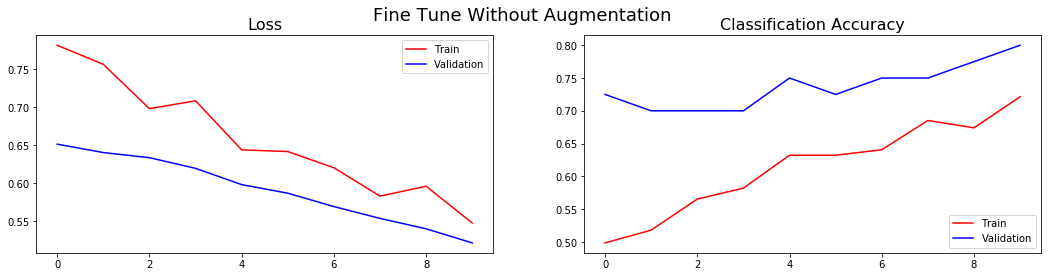

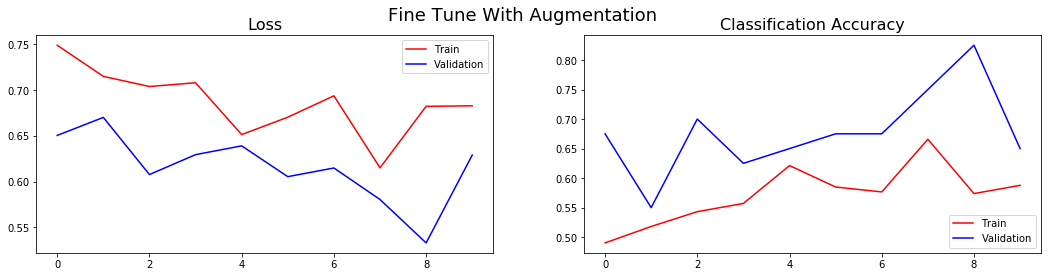

In [0]:
def summarize_stats(history,title):                                             # Function to plot summary and statistics
  # loss 
  plt.figure(figsize=(18,4))                                                    # Initialize a figure
  plt.subplot(1,2,1)
  plt.suptitle(title,fontsize=18)
  plt.title('Loss',fontsize=16)                                                 # Set title of the first subplot
  plt.plot(history.history['loss'], color='red', label='Train')                 # Plot training loss
  plt.plot(history.history['val_loss'], color='blue', label='Validation')       # Plot validation loss
  plt.legend(loc='upper right')
  # accuracy
  plt.subplot(1,2,2)
  plt.title('Classification Accuracy',fontsize=16)                              # Set title of second subplot
  plt.plot(history.history['acc'], color='red', label='Train')                  # Plot training accuracy
  plt.plot(history.history['val_acc'], color='blue', label='Validation')        # Plot validation accuracy
  
  plt.legend(loc='lower right')
  plt.show()
  
for it,model in enumerate(models):
  summarize_stats(model_outputs[it],title=str(categories[it]))                  # Print summary for each model outputs history


## Testing Pretrained Model


### Model Weights
The weights of the model were stored in **vgg_nonaug_checkpoints/** directory and **vgg_aug_checkpoints/** directory, after every 2 epochs. We will list down those weights files.

In [0]:
print('\nModel for Non Augmented Data: ')
print(os.listdir(nonaugweightsdir_ft))
print('\nModel for Augmented Data: ')
print(os.listdir(augweightsdir_ft))



Model for Non Augmented Data: 
['weights.06-0.59.hdf5', 'weights.02-0.64.hdf5', 'weights.03-0.63.hdf5', 'weights.01-0.65.hdf5', 'weights.07-0.57.hdf5', 'weights.05-0.60.hdf5', 'weights.09-0.54.hdf5', 'weights.04-0.62.hdf5', 'weights.08-0.55.hdf5', 'weights.10-0.52.hdf5']

Model for Augmented Data: 
['weights.03-0.61.hdf5', 'weights.04-0.63.hdf5', 'weights.07-0.61.hdf5', 'weights.06-0.61.hdf5', 'weights.08-0.58.hdf5', 'weights.09-0.53.hdf5', 'weights.01-0.65.hdf5', 'weights.05-0.64.hdf5', 'weights.02-0.67.hdf5', 'weights.10-0.63.hdf5']


### Weight Loading
For our convolutional model, we will load weights from file and evalute on test data. We can load  weight file stored in directory **vgg_nonaug_checkpoints/** or **vgg_aug_checkpoints/**

In [0]:

models[0].load_weights(glob.glob('vgg_nonaug_checkpoints/*')[-1])               # Load model weights trained on non augmented data
models[1].load_weights(glob.glob('vgg_aug_checkpoints/*')[-2])                  # Load model weights trained on augmented data

for it,model in enumerate(models):
  print(categories[it])
  
  # Evaluate model on testing data
  test_loss, accuracy = model.evaluate_generator(testing_iterators[it],len(testing_iterators[it]), verbose=1)
  print('Testing loss: %.2f, Accuracy: %.2f' % (test_loss,accuracy * 100.0))


Fine Tune Without Augmentation
4/4 [==============================] - 51s 13s/step
Testing loss: 0.58, Accuracy: 71.00
Fine Tune With Augmentation
4/4 [==============================] - 55s 14s/step
Testing loss: 0.71, Accuracy: 49.00


### Visualizing Predictions

In [0]:
predictions=[]
for it,model in enumerate(models):
  print(categories[it])
  
  # Store model predictions
  predictions.append(model.predict_generator(testing_iterators[it],len(testing_iterators[it])))          
  
random_selection=np.random.choice(len(x_test),24)

Fine Tune Without Augmentation
Fine Tune With Augmentation


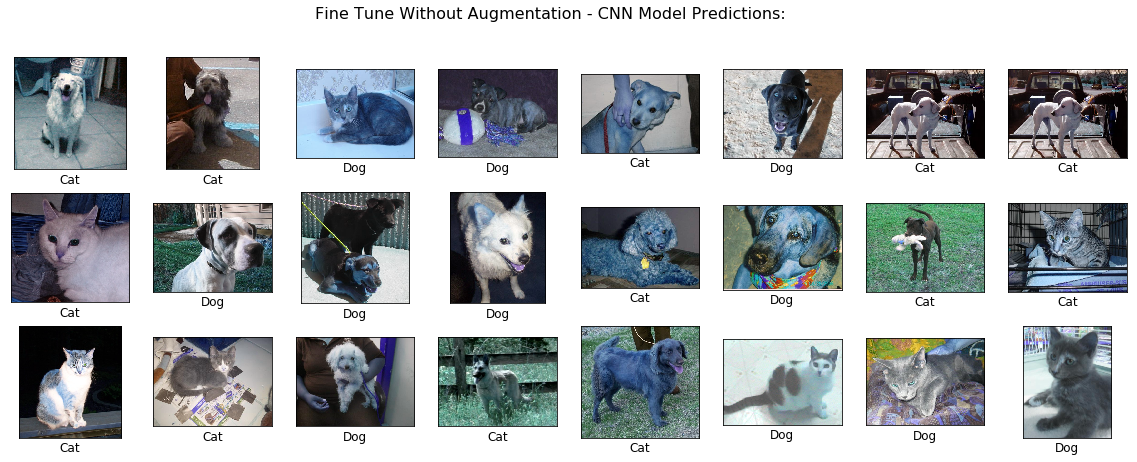

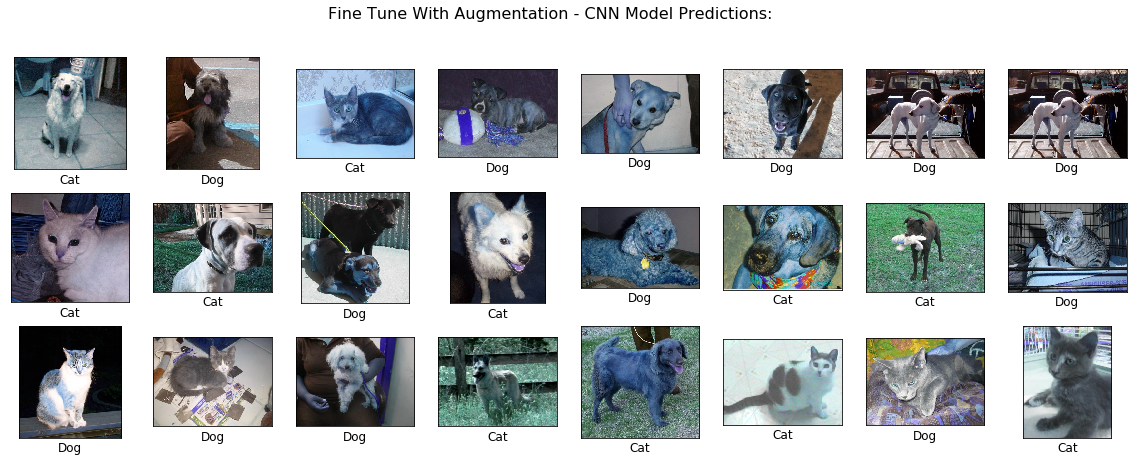

In [0]:
for it,prediction in enumerate(predictions):
  plt.figure(figsize=(20,7))                                                    # Initialize a figure                                       
  plt.suptitle(str(categories[it])+' - CNN Model Predictions:',fontsize=16)
  for i in range(24):
      plt.subplot(3,8,i+1)                                                      # Initialize and select current subplot
      plt.grid(False)                                                           # Set off the gridlines
      plt.xticks([])                                                            # Set off x axis values
      plt.yticks([])                                                            # Set off y axis values
      plt.imshow(cv2.imread(x_test[random_selection[i]]), cmap='gray')          # Show the image in current subplot
      plt.xlabel(str(C2[np.argmax(prediction[random_selection[i]])]),fontsize=12)
  plt.show()

### Confusion Matrix:
Confusion matrix will show how many instances from each class have been correctly or incorrectly classified from our finetuned model.

(100, 2)

 Fine Tune Without Augmentation Accuracy Metrics for each class:
              precision    recall  f1-score   support

           0       0.40      0.45      0.42        47
           1       0.46      0.42      0.44        53

    accuracy                           0.43       100
   macro avg       0.43      0.43      0.43       100
weighted avg       0.43      0.43      0.43       100


 Fine Tune With Augmentation Accuracy Metrics for each class:
              precision    recall  f1-score   support

           0       0.53      0.64      0.58        47
           1       0.60      0.49      0.54        53

    accuracy                           0.56       100
   macro avg       0.57      0.56      0.56       100
weighted avg       0.57      0.56      0.56       100



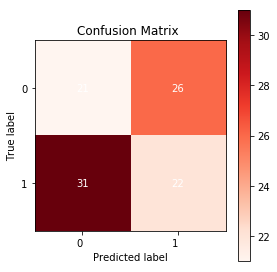

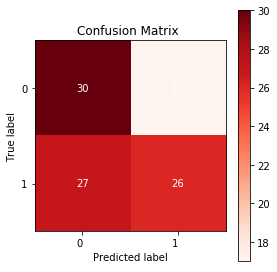

In [0]:
def plot_confusion_matrix(y_true, y_pred, titletxt,
                          cmap=plt.cm.Reds):                                    # To plot confusion matrix
    
    cm = confusion_matrix(y_true, y_pred)                                       # Get confusion matrix from actual y labels and predicted y labels
    classes = range(0,2)                                                        # Two classes: cats and dogs

    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)                      # Show confusion matrix in axes/subplot
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix ',
           ylabel='True label',
           xlabel='Predicted label')                                            # Set properties of axes/subplots

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

  

one_hot_y_test=to_categorical(y_test,num_classes=2)                             # Convert labels to one hot encoding to train the model
print(one_hot_y_test.shape)
for it,prediction in enumerate(predictions):
  predicted=np.argmax(prediction,axis=1)                                        # Get predicted label
  actual=np.argmax(np.array(one_hot_y_test),axis=1)                             # Convert one hot encoded labels to indices
  plot_confusion_matrix(actual,predicted,categories[it])                        # Plot confusion matrix
  print('\n',categories[it],'Accuracy Metrics for each class:')
  print(classification_report(actual,predicted))                                # Print classification report


We can clearly see that pretrained model is way better than a simple randomly initialized model. Most of the images have been correctly classified even when the model is trained on just 5000 images and for only 10 epochs. Training the models on all images will certainly improve the model performance by a large margin